# Fish Segmentation : Issue #141

### Models Used : VGGNet, ResNet

In [1]:
#importing libraries
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

from keras.layers import GlobalAveragePooling2D,Dropout,Concatenate,AveragePooling2D,Add,MaxPooling2D,BatchNormalization,ZeroPadding2D,Input,Rescaling,Dense,Flatten,MaxPool2D,Conv2D,Activation,Dropout,RandomRotation,RandomTranslation,RandomContrast,RandomBrightness

from keras import backend as K
import keras

import cv2
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Sequential, Model
from keras.models import load_model

from keras.optimizers import Adam
from keras.callbacks import EarlyStopping,ModelCheckpoint

import keras.applications as saved

import os
import PIL
import PIL.Image
import pathlib

In [2]:
#Model implemetation for each VGGNET

def model_VGG16():
    model = Sequential()
    model.add(Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
    model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2),name='lastConvpointer'))
    model.add(Flatten(name='flatten'))
    model.add(Rescaling(1./255))
    model.add(Dense(4096, activation='relu', name='fc1'))
    model.add(Dense(4096, activation='relu', name='fc2'))
    model.add(Dense(9, activation='softmax', name='output')) 
    return model

In [3]:
#model implemetation for ResNet

def identity_block(X, f, filters):
    F1, F2, F3 = filters
    X_skip = X
    X = Conv2D(filters = F1, kernel_size = 1, strides = (1,1), padding = 'valid')(X)
    X = BatchNormalization(axis = 3)(X) 
    X = Activation('relu')(X)
    X = Conv2D(filters = F2, kernel_size = f, strides = (1,1), padding = 'same')(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = Conv2D(filters = F3, kernel_size = 1, strides = (1,1), padding = 'valid')(X)
    X = BatchNormalization(axis = 3)(X)
    X = Add()([X,X_skip])
    X = Activation('relu')(X) 
    return X

def convolutional_block(X, f, filters, s = 2):
    
    F1, F2, F3 = filters
    X_skip = X
    X = Conv2D(filters = F1, kernel_size = 1, strides = (s, s), padding='valid')(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = Conv2D(filters = F2, kernel_size = f, strides = (1, 1), padding='same')(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = Conv2D(filters = F3, kernel_size = 1, strides = (1, 1), padding='valid')(X)
    X = BatchNormalization(axis = 3)(X)
    X_skip = Conv2D(filters = F3, kernel_size = 1, strides = (s, s), padding='valid')(X_skip)
    X_skip = BatchNormalization(axis = 3)(X_skip)
    X = Add()([X, X_skip])
    X = Activation('relu')(X)    
    return X


def model_ResNet50(input_shape = (64, 64, 3)):

    X_input = Input(input_shape)
    X = ZeroPadding2D((3, 3))(X_input)
    X = Conv2D(64, (7, 7), strides = (2, 2))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], s = 1)
    X = identity_block(X, 3, [64, 64, 256])
    X = identity_block(X, 3, [64, 64, 256])
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], s = 2) 
    X = identity_block(X, 3, [128, 128, 512]) 
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512]) 
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], s = 2) 
    X = identity_block(X, 3, [256, 256, 1024]) 
    X = identity_block(X, 3, [256, 256, 1024]) 
    X = identity_block(X, 3, [256, 256, 1024]) 
    X = identity_block(X, 3, [256, 256, 1024]) 
    X = identity_block(X, 3, [256, 256, 1024]) 
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], s = 2)  
    X = identity_block(X, 3, [512, 512, 2048])
    X = identity_block(X, 3, [512, 512, 2048]) 
    X = AveragePooling2D(name = 'lastTRAINlayer')(X)
    X = Flatten()(X)
    X = Rescaling(1./255)(X)
    X = Dense(2048, activation = 'relu')(X)
    X = Dense(2048, activation = 'relu')(X)
    X = Dense(9, activation='softmax')(X)
    model = Model(inputs = X_input, outputs = X)

    return model

In [4]:
#Making the training path ( for all the fishes )

trainingpath = r"C:/Users/evanj/Desktop/Fish Segmentation/Dataset/Classification Set Augmented"
class_names=os.listdir(trainingpath)
data_dir = trainingpath
data_dir = pathlib.Path(data_dir)
image_count = len(list(data_dir.glob('*/*.jpg')))

#Changing the image dimensions according to out VGG_NET
img_heightVGG = 224
img_widthVGG = 224

total_dsVGG = keras.utils.image_dataset_from_directory(
  data_dir,image_size=(img_heightVGG, img_widthVGG),batch_size=32,label_mode='categorical')

img_heightResNet = 64
img_widthResNet = 64

total_dsResNet = keras.utils.image_dataset_from_directory(
  data_dir,image_size=(img_heightResNet, img_widthResNet),batch_size=8, label_mode = 'categorical')

class_names = total_dsVGG.class_names
print(class_names)

Found 9000 files belonging to 9 classes.
Found 9000 files belonging to 9 classes.
['Black Sea Sprat', 'Gilt-Head Bream', 'Hourse Mackerel', 'Red Mullet', 'Red Sea Bream', 'Sea Bass', 'Shrimp', 'Striped Red Mullet', 'Trout']


In [5]:
#Splitting the total dataset to train and validation
train_dsVGG ,val_dsVGG= keras.utils.split_dataset(total_dsVGG,left_size = 0.8, right_size = 0.2, seed=7)
train_dsResNet ,val_dsResNet= keras.utils.split_dataset(total_dsResNet,left_size = 0.8, right_size = 0.2, seed=7)

In [6]:
VGGModel = model_VGG16()

#to select the layers which we are going to add weights from original VGG_NET (found from kaggle, is cited below)

Layers_not2bTND = Model(inputs=VGGModel.input, outputs=VGGModel.get_layer('lastConvpointer').output)
Layers_not2bTND.load_weights(r"C:/Users/evanj/Desktop/Fish Segmentation/extras/vgg16_weights.h5")

#to prevent the convlayers to train

for layer in Layers_not2bTND.layers:
    layer.trainable = False
    
VGGModel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                    

In [7]:
#Using ADAM as optimiser here.
#lr_rate = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate = 0.01, decay_steps = 10000, decay_rate = 0.99)
opt = Adam(learning_rate=0.01,beta_1=0.9,beta_2=0.999,epsilon=1e-07)
#Compiling the Model
VGGModel.compile(loss="categorical_crossentropy",optimizer = opt, metrics = ["accuracy"])

#defining Early Stopping to prevent overfitting
esVGG=EarlyStopping(monitor='val_accuracy', mode='max', patience=10)
#To save the best Model
mcVGG = ModelCheckpoint(r"C:/Users/evanj/Desktop/Fish Segmentation/extras/bestVGG_model.h5", monitor='val_accuracy', mode='max', save_best_only=True)

In [8]:
#for the ResNet now

ResNetModel = model_ResNet50()
Layers_not2bTND = Model(inputs=ResNetModel.input, outputs=ResNetModel.get_layer('lastTRAINlayer').output)
Layers_not2bTND.load_weights(r"C:/Users/evanj/Desktop/Fish Segmentation/extras/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5")

#to prevent the convlayers to train

for layer in Layers_not2bTND.layers:
    layer.trainable = False
    
ResNetModel.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 70, 70, 3)   0           ['input_1[0][0]']                
                                                                                                  
 conv2d_13 (Conv2D)             (None, 32, 32, 64)   9472        ['zero_padding2d[0][0]']         
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 64)  256         ['conv2d_13[0][0]']              
 alization)                                                                                 

 conv2d_23 (Conv2D)             (None, 15, 15, 256)  16640       ['activation_8[0][0]']           
                                                                                                  
 batch_normalization_10 (BatchN  (None, 15, 15, 256)  1024       ['conv2d_23[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 add_2 (Add)                    (None, 15, 15, 256)  0           ['batch_normalization_10[0][0]', 
                                                                  'activation_6[0][0]']           
                                                                                                  
 activation_9 (Activation)      (None, 15, 15, 256)  0           ['add_2[0][0]']                  
                                                                                                  
 conv2d_24

                                                                  'activation_15[0][0]']          
                                                                                                  
 activation_18 (Activation)     (None, 8, 8, 512)    0           ['add_5[0][0]']                  
                                                                                                  
 conv2d_34 (Conv2D)             (None, 8, 8, 128)    65664       ['activation_18[0][0]']          
                                                                                                  
 batch_normalization_21 (BatchN  (None, 8, 8, 128)   512         ['conv2d_34[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_19 (Activation)     (None, 8, 8, 128)    0           ['batch_normalization_21[0][0]'] 
          

 batch_normalization_31 (BatchN  (None, 4, 4, 256)   1024        ['conv2d_44[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_28 (Activation)     (None, 4, 4, 256)    0           ['batch_normalization_31[0][0]'] 
                                                                                                  
 conv2d_45 (Conv2D)             (None, 4, 4, 256)    590080      ['activation_28[0][0]']          
                                                                                                  
 batch_normalization_32 (BatchN  (None, 4, 4, 256)   1024        ['conv2d_45[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activatio

                                                                                                  
 conv2d_55 (Conv2D)             (None, 4, 4, 1024)   263168      ['activation_38[0][0]']          
                                                                                                  
 batch_normalization_42 (BatchN  (None, 4, 4, 1024)  4096        ['conv2d_55[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 add_12 (Add)                   (None, 4, 4, 1024)   0           ['batch_normalization_42[0][0]', 
                                                                  'activation_36[0][0]']          
                                                                                                  
 activation_39 (Activation)     (None, 4, 4, 1024)   0           ['add_12[0][0]']                 
          

 add_15 (Add)                   (None, 2, 2, 2048)   0           ['batch_normalization_52[0][0]', 
                                                                  'activation_45[0][0]']          
                                                                                                  
 activation_48 (Activation)     (None, 2, 2, 2048)   0           ['add_15[0][0]']                 
                                                                                                  
 lastTRAINlayer (AveragePooling  (None, 1, 1, 2048)  0           ['activation_48[0][0]']          
 2D)                                                                                              
                                                                                                  
 flatten (Flatten)              (None, 2048)         0           ['lastTRAINlayer[0][0]']         
                                                                                                  
 rescaling

In [9]:
#Using ADAM as optimiser here.
#lr_rate = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate = 0.01, decay_steps = 10000, decay_rate = 0.99)
opt = Adam(learning_rate=0.01,beta_1=0.9,beta_2=0.99,epsilon=1e-07)
#Compiling the Model
ResNetModel.compile(loss="categorical_crossentropy",optimizer = opt, metrics = ["accuracy"])

#defining Early Stopping to prevent overfitting
esResNet=EarlyStopping(monitor='val_accuracy', mode='max', patience=10)
#To save the best Model
mcResNet = ModelCheckpoint(r"C:/Users/evanj/Desktop/Fish Segmentation/extras/bestResNet_model.h5", monitor='val_accuracy', mode='max', save_best_only=True)

In [10]:
#Creating the model.
HVGG = VGGModel.fit(train_dsVGG,batch_size=1,validation_data=val_dsVGG,epochs=100,verbose=1,callbacks=[mcVGG,esVGG])

Epoch 1/100
225/225 [==============================] - 592s 3s/step - loss: 1.8348 - accuracy: 0.8597 - val_loss: 0.1935 - val_accuracy: 0.9606
Epoch 2/100
225/225 [==============================] - 600s 3s/step - loss: 0.1763 - accuracy: 0.9724 - val_loss: 0.4663 - val_accuracy: 0.9450
Epoch 3/100
225/225 [==============================] - 592s 3s/step - loss: 0.3652 - accuracy: 0.9665 - val_loss: 0.3018 - val_accuracy: 0.9844
Epoch 4/100
225/225 [==============================] - 590s 3s/step - loss: 0.3263 - accuracy: 0.9804 - val_loss: 0.0867 - val_accuracy: 0.9906
Epoch 5/100
225/225 [==============================] - 591s 3s/step - loss: 0.0387 - accuracy: 0.9954 - val_loss: 0.3163 - val_accuracy: 0.9839
Epoch 6/100
225/225 [==============================] - 591s 3s/step - loss: 0.0841 - accuracy: 0.9940 - val_loss: 0.1463 - val_accuracy: 0.9806
Epoch 7/100
225/225 [==============================] - 588s 3s/step - loss: 0.1882 - accuracy: 0.9862 - val_loss: 0.3629 - val_accuracy:

In [11]:
HResNet = ResNetModel.fit(train_dsResNet,validation_data=val_dsResNet,epochs=100,verbose=1,callbacks=[mcResNet,esResNet])

Epoch 1/100
900/900 [==============================] - 84s 89ms/step - loss: 0.7835 - accuracy: 0.7161 - val_loss: 0.4774 - val_accuracy: 0.8367
Epoch 2/100
900/900 [==============================] - 79s 87ms/step - loss: 0.3706 - accuracy: 0.8715 - val_loss: 0.3557 - val_accuracy: 0.8939
Epoch 3/100
900/900 [==============================] - 78s 86ms/step - loss: 0.2612 - accuracy: 0.9142 - val_loss: 0.3148 - val_accuracy: 0.8900
Epoch 4/100
900/900 [==============================] - 78s 86ms/step - loss: 0.2267 - accuracy: 0.9322 - val_loss: 0.4458 - val_accuracy: 0.8961
Epoch 5/100
900/900 [==============================] - 78s 86ms/step - loss: 0.2077 - accuracy: 0.9425 - val_loss: 0.3053 - val_accuracy: 0.9239
Epoch 6/100
900/900 [==============================] - 77s 86ms/step - loss: 0.1676 - accuracy: 0.9517 - val_loss: 0.3250 - val_accuracy: 0.9228
Epoch 7/100
900/900 [==============================] - 78s 86ms/step - loss: 0.1382 - accuracy: 0.9600 - val_loss: 0.2757 - val_ac

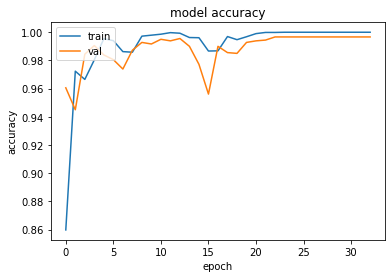

In [12]:
#Plotting accuracy
plt.plot(VGGModel.history.history['accuracy'])
plt.plot(VGGModel.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

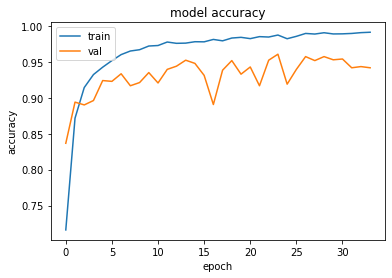

In [13]:
#Plotting accuracy
plt.plot(ResNetModel.history.history['accuracy'])
plt.plot(ResNetModel.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()